<a href="https://colab.research.google.com/github/JingRu-hi/mango-grade/blob/main/Mango_Grade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from torchvision import transforms
from torchvision import models
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.optim import lr_scheduler
from torch import optim
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader 
import glob

In [ ]:
# 資料處理套件
import os
import cv2
import csv
import random
import time
import numpy as np
import pandas as pd
import matplotlib.image as mpimg # mpimg 用於讀取圖片
import matplotlib.pyplot as plt # plt 用於顯示圖片
import seaborn as sns
from PIL import Image

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"  #強制進行同步計算  #防止runtime error(59) 

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

# 2. import data

In [ ]:
# 取得drive驗證
from google.colab import drive
import pandas as pd
drive.mount('/content/gdrive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
train_label = pd.read_csv("/content/gdrive/My Drive/Mango/train.csv",encoding="utf8")

In [ ]:
dev_label = pd.read_csv("/content/gdrive/My Drive/Mango/dev.csv",encoding="utf8")

In [ ]:
# 串接圖片檔的路徑
train_image_path = os.path.join("/content/gdrive/My Drive/Mango/C1-P1_Train")

In [ ]:
# 讀取路徑中的圖片
train_image = os.listdir(train_image_path)

# 資料前處理

In [ ]:
train_label.head()

,image_id,label
0,00002.jpg,C
1,00003.jpg,C
2,00004.jpg,B
3,00005.jpg,A
4,00007.jpg,A


In [ ]:
train_label[train_label['label']=='A']=0
train_label[train_label['label']=='B']=1
train_label[train_label['label']=='C']=2

In [ ]:
dev_label[dev_label['label']=='A']=0
dev_label[dev_label['label']=='B']=1
dev_label[dev_label['label']=='C']=2
dev_label.head()

,image_id,label
0,1,1
1,0,0
2,1,1
3,1,1
4,2,2


## EDA

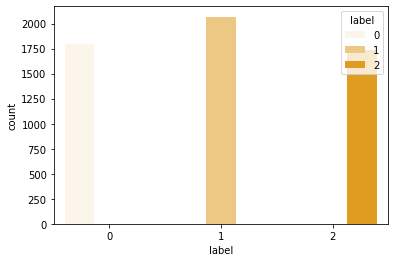

In [ ]:
# Show the bar plot
sns.countplot(train_label['label'],hue = train_label['label'],color='orange')

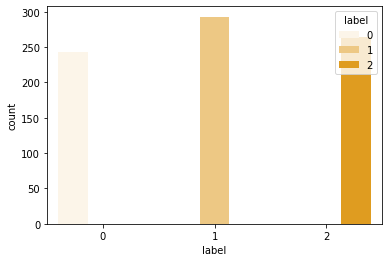

In [ ]:
# Show the bar plot
sns.countplot(dev_label['label'],hue = dev_label['label'],color='orange')

In [ ]:
sector = train_label.groupby('label')
sector.size()

label
0    1792
1    2068
2    1740
dtype: int64

In [ ]:
train_sec = dev_label.groupby('label')
train_sec.size()

label
0    243
1    293
2    264
dtype: int64

In [ ]:
train_label

,image_id,label
0,2,2
1,2,2
2,1,1
3,0,0
4,0,0
...,...,...
5595,2,2
5596,0,0
5597,0,0
5598,0,0


# 3.顯示圖片

In [ ]:
img = mpimg.imread("/content/gdrive/My Drive/Mango/C1-P1_Train/00002.jpg")

In [ ]:
# 顯示原始圖片的比例
img.shape

(1008, 1344, 3)

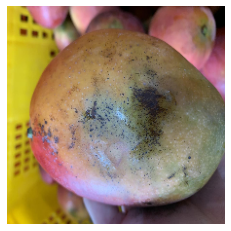

In [ ]:
# 將影像壓縮 224*224
res = cv2.resize(img,(224,224),interpolation=cv2.INTER_LINEAR)
# 顯示壓縮過原圖的芒果照片
plt.imshow(res)
plt.axis('off')
plt.show()

In [ ]:
# 顯示壓縮後圖片的比例
res.shape

(224, 224, 3)

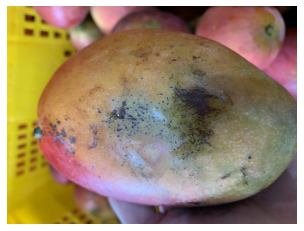

In [ ]:
# 顯示原圖的芒果照片
plt.imshow(img)
plt.axis('off')
plt.show()

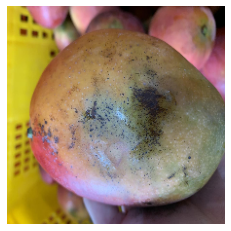

In [ ]:
# 顯示壓縮過原圖的芒果照片
plt.imshow(res)
plt.axis('off')
plt.show()

# 4. Pytorch 建立資料庫

In [ ]:
def default_loader(path):
    return Image.open(path).convert('RGB') #確認轉出來的色彩模式為RGB

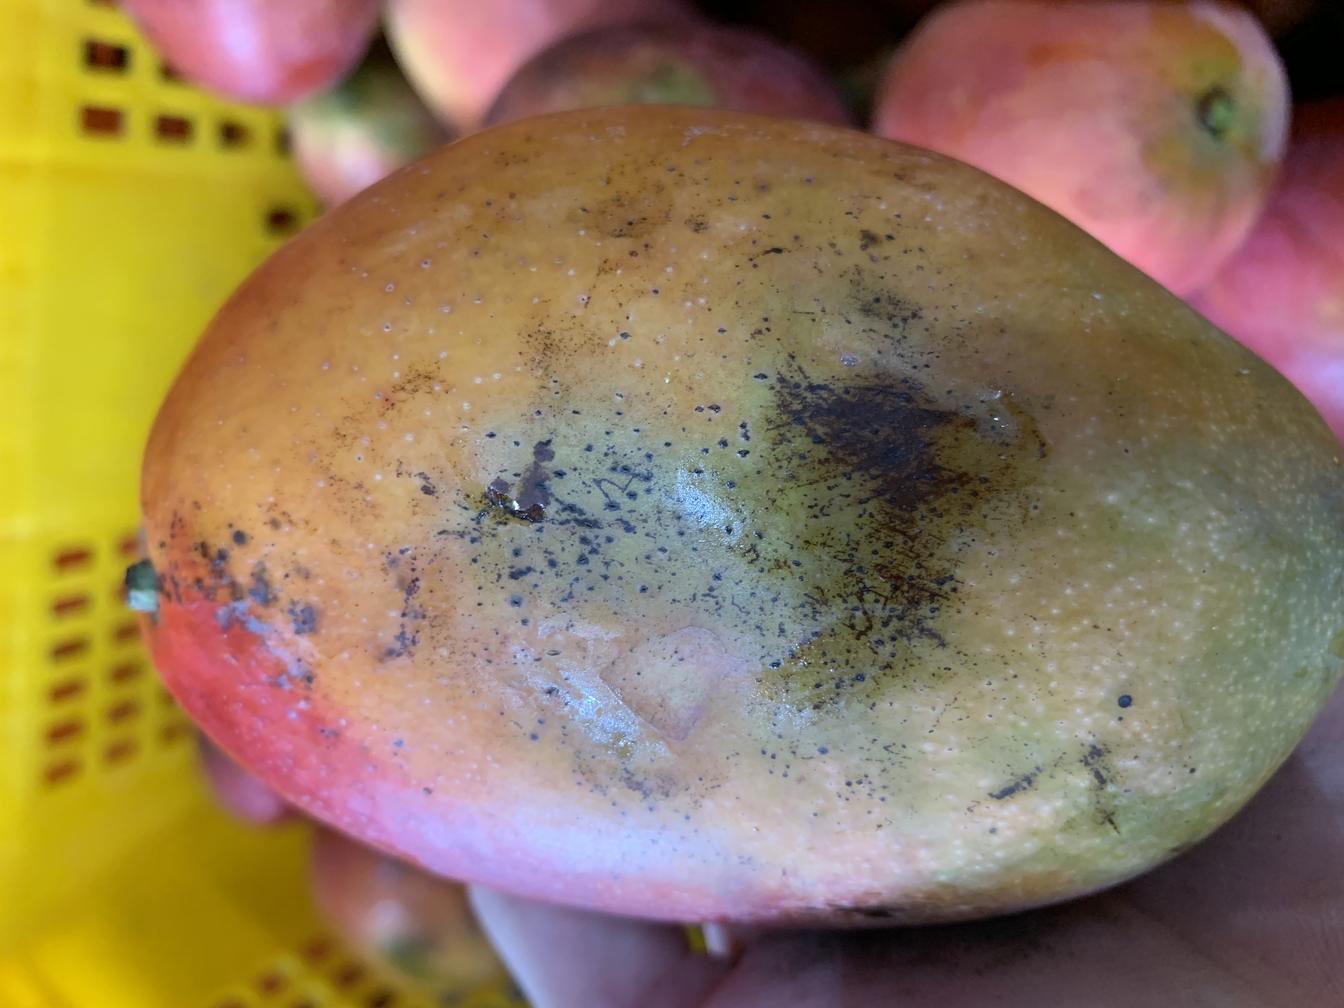

In [ ]:
# 讀取圖片
default_loader("/content/gdrive/My Drive/Mango/C1-P1_Train/00002.jpg")

In [ ]:
Train_dataloader = DataLoader(
    dataset=mangoImageFloder(img_path=path+'C1-P1_Train/',
                             label_path=path+'train.csv',transform= transform),
    batch_size=4,
    shuffle=False)

In [ ]:
Test_dataloader = DataLoader(
    dataset=mangoImageFloder(img_path=path+'C1-P1_Dev/',
                             label_path=path+'dev.csv',transform= transform),
    batch_size=4,
    shuffle=False)

In [ ]:
path='/content/gdrive/My Drive/Mango/'

In [ ]:
class mangoImageFloder(Dataset):
    def __init__(self, img_path, label_path,transform = None):
        super().__init__()
        ##############################################
        ### Initialize paths, transforms, and so on
        ##############################################
        self.label = pd.read_csv(label_path)
        self.image_all_path = glob.glob(os.path.join(img_path, '*.jpg'))
        self.transform = transform
    def __len__(self):
        ##############################################
        # 1. Read from file (using numpy.fromfile, PIL.Image.open)
        # 2. Preprocess the data (torchvision.Transform).
        # 3. Return the data (e.g. image and label)
        ##############################################
        return len(self.image_all_path)
    def __getitem__(self, index):
        ##############################################
        ### Indicate the total size of the dataset
        ##############################################
        img = Image.open(self.image_all_path[index])
        img_name = self.label['image_id'][index]
        img_label = self.label["label"][index]
        if self.transform is not None:
            return self.transform(img), img_label
        else:
            return img, img_label

In [ ]:
transform = transforms.Compose([transforms.Resize((224, 224)), ##調整size 到同一尺寸
                                transforms.RandomHorizontalFlip(), #隨意做旋轉
                                transforms.ToTensor(),
                                transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))])

In [ ]:
mangoImageFloder(img_path=path+'C1-P1_Train/',label_path=path+'train.csv',transform= transform)

In [ ]:
Train_dataloader = DataLoader(dataset=mangoImageFloder(img_path=path+'C1-P1_Train/',label_path=path+'train.csv',transform= transform),
           batch_size=4,
           shuffle=False)

In [ ]:
Test_dataloader = DataLoader(dataset=mangoImageFloder(img_path=path+'C1-P1_Dev/',label_path=path+'dev.csv',transform= transform),
           batch_size=4,
           shuffle=False)

# 5. Modeling

In [ ]:
# GPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'   ##檢查是否有GPU 如果有用GPU的狀態 沒有則用CPU的狀態
print('GPU state:', device)

GPU state: cuda:0


In [ ]:
model = models.resnet18(pretrained=True)
model.fc

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


Linear(in_features=512, out_features=1000, bias=True)

In [ ]:
num_ftrs  = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)
model.fc

Linear(in_features=512, out_features=3, bias=True)

In [ ]:
model = model.cuda()

In [ ]:
# Loss and Optimizer
learning_rate = 0.001
loss_function = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Training

In [ ]:
for epoch in range(2): ##迭代4次
  
    running_loss= 0.0

    for i,data in enumerate(Train_dataloader,0): ##enumerate(,0):表示索引從0開始
        iter (Train_dataloader).next()
        inputs, labels = data
        #labels = np.asarray(labels)
        #labels = torch.from_numpy(labels)
        #print(type(labels))
        #print(type(inputs))
        inputs = inputs.to(device)  ##將資料交給GPU運算
        
        labels = labels.to(device)
        optimizer_ft.zero_grad() ##每次在更新權重前清空梯度，不然梯度會一直累積。

        outputs = model(inputs) ##將圖片數據丟入神經網路 產出估計值
        loss = loss_function(outputs, labels) ##計算估計值與真實值的loss function
        loss.backward() ##呼叫 loss 的 backward() 方法開始進行反向傳播
        optimizer_ft.step() ##呼叫 optimizer 的 step() 方法來更新權重。

        running_loss += loss.item() ##每次累計其loss值
        if i%200 == 199:
            print('[%d, %5d] loss: %.3f'%(epoch+1,i+1,running_loss/200)) ##計算每500筆資料的平均loss
            running_loss = 0.0 ##每500清空一次 running loss

print("Training finished")

In [ ]:
model 